<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [149]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [150]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [151]:
# abro el archivo y me guardo todas las líneas
with open('A_journey_to_the_Center_of_the_earth.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

# busco dónde arranca y termina el texto útil
start_idx = next(i for i, line in enumerate(lines) if '*** START OF' in line)
end_idx = next(i for i, line in enumerate(lines) if '*** END OF' in line)
#end_idx = next(i for i, line in enumerate(lines) if 'But I thought it best not to urge this argument' in line)

# me quedo con las líneas del medio
main_text_lines = lines[start_idx + 1:end_idx]

# saco saltos de línea y uno todo en una sola string
main_text = ' '.join(line.strip() for line in main_text_lines)

# paso a minúsculas
article_text = main_text.lower()


In [152]:
import lxml
print(lxml.__version__)

6.0.0


In [153]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

"    produced by norm wolcott      a journey to the centre of the earth  by jules verne     [redactor's note: journey to the centre of the earth is number v002 in the taves and michaluk numbering of the works of jules verne. first published in england by griffith and farran, 1871, this edition is not a translation at all but a complete re-write of the novel, with portions added and omitted, and names changed. the most reprinted version, it is entered into project gutenberg for reference purposes only. a better translation is _a journey into the interior of the earth_ translated by rev. f. a. malleson, also available on project gutenberg.]     table of contents  chapter 1 my uncle makes a great discovery  chapter 2 the mysterious parchment  chapter 3 an astounding discovery  chapter 4 we start on the journey  chapter 5 first lessons in climbing  chapter 6 our voyage to iceland  chapter 7 conversation and discovery  chapter 8 the eider-down hunter--off at last  chapter 9 our start--we me

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [154]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [155]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [156]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [157]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

54

In [158]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [159]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [160]:
tokenized_text[:1000]

[24,
 24,
 24,
 24,
 10,
 53,
 16,
 32,
 43,
 13,
 11,
 32,
 24,
 35,
 47,
 24,
 4,
 16,
 53,
 36,
 24,
 25,
 16,
 51,
 13,
 16,
 39,
 39,
 24,
 24,
 24,
 24,
 24,
 24,
 40,
 24,
 18,
 16,
 43,
 53,
 4,
 11,
 47,
 24,
 39,
 16,
 24,
 39,
 50,
 11,
 24,
 13,
 11,
 4,
 39,
 53,
 11,
 24,
 16,
 8,
 24,
 39,
 50,
 11,
 24,
 11,
 40,
 53,
 39,
 50,
 24,
 24,
 35,
 47,
 24,
 18,
 43,
 51,
 11,
 20,
 24,
 6,
 11,
 53,
 4,
 11,
 24,
 24,
 24,
 24,
 24,
 7,
 53,
 11,
 32,
 40,
 13,
 39,
 16,
 53,
 5,
 20,
 24,
 4,
 16,
 39,
 11,
 2,
 24,
 18,
 16,
 43,
 53,
 4,
 11,
 47,
 24,
 39,
 16,
 24,
 39,
 50,
 11,
 24,
 13,
 11,
 4,
 39,
 53,
 11,
 24,
 16,
 8,
 24,
 39,
 50,
 11,
 24,
 11,
 40,
 53,
 39,
 50,
 24,
 49,
 20,
 24,
 4,
 43,
 36,
 35,
 11,
 53,
 24,
 6,
 33,
 33,
 0,
 24,
 49,
 4,
 24,
 39,
 50,
 11,
 24,
 39,
 40,
 6,
 11,
 20,
 24,
 40,
 4,
 32,
 24,
 36,
 49,
 13,
 50,
 40,
 51,
 43,
 29,
 24,
 4,
 43,
 36,
 35,
 11,
 53,
 49,
 4,
 41,
 24,
 16,
 8,
 24,
 39,
 50,
 11,
 24,
 25,
 16,
 5

### Organizando y estructurando el dataset

In [161]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [162]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [163]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [164]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [165]:
#X = np.array(tokenized_sentences_train[:-1])
#y = np.array(tokenized_sentences_train[1:])
X = np.array([seq[:-1] for seq in tokenized_sentences_train])
y = np.array([seq[1:] for seq in tokenized_sentences_train])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [166]:
X.shape

(437582, 99)

In [167]:
X[0,:10]

array([24, 24, 24, 24, 10, 53, 16, 32, 43, 13])

In [168]:
y[0,:10]

array([24, 24, 24, 10, 53, 16, 32, 43, 13, 11])

In [169]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

In [170]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, LSTM, GRU, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [171]:
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=None))  
model_rnn.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_rnn.add(Dense(vocab_size, activation='softmax'))
model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

In [172]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=None))  
model_lstm.add(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_lstm.add(Dense(vocab_size, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')


In [173]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=None)) 
model_gru.add(GRU(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_gru.add(Dense(vocab_size, activation='softmax'))
model_gru.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')



### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [174]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, model_name, patience=3):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience
      
      self.model_name = model_name
      self.history_ppl = history_ppl

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(self.model_name)
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [ ]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
#history_ppl_rnn = []
#hist_rnn = model_rnn.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_rnn,model_name="model_rnn.keras")], batch_size=256)

#history_ppl_lstm = []
#hist_lstm = model_lstm.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_lstm,model_name="model_lstm.keras")], batch_size=256)

#history_ppl_gru = []
#hist_gru = model_gru.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_gru,model_name="model_gru.keras")], batch_size=256)

Epoch 1/20
1709/1710 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 2.0735
 mean perplexity: 5.489458288042274 

Saved new model!
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 176s 102ms/step - loss: 2.0732
Epoch 2/20
1709/1710 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 1.5514
 mean perplexity: 4.9105409724634175 

Saved new model!
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 195s 114ms/step - loss: 1.5514
Epoch 3/20
1709/1710 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 1.4980
 mean perplexity: 4.836912439516124 

Saved new model!
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 207s 121ms/step - loss: 1.4980
Epoch 4/20
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - loss: 1.4768 
 mean perplexity: 4.769280535079318 

Saved new model!
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 27496s 16s/step - loss: 1.4768
Epoch 5/20
1709/1710 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 1.4632
 mean perplexity: 4.602250555002395 

Saved new model!
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 171s 100ms/step - loss: 1.4632
Epoch 6/20
1709/1710 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 

In [ ]:
import numpy as np

#np.save("history_ppl_rnn.npy", np.array(history_ppl_rnn))
#np.save("history_ppl_lstm.npy", np.array(history_ppl_lstm))
#np.save("history_ppl_gru.npy", np.array(history_ppl_gru))

# Para cargar los historiales de perplejidad
history_ppl_rnn = np.load("history_ppl_rnn.npy").tolist()
history_ppl_lstm = np.load("history_ppl_lstm.npy").tolist()
history_ppl_gru = np.load("history_ppl_gru.npy").tolist()



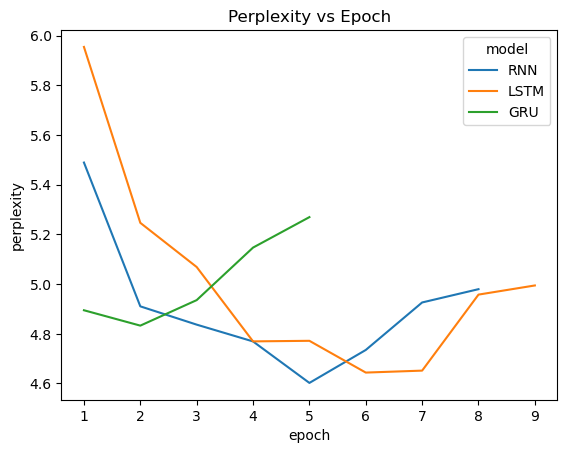

In [177]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame([
    {"epoch": i, "perplexity": val, "model": m}
    for m, history in zip(["RNN","LSTM","GRU"], [history_ppl_rnn, history_ppl_lstm, history_ppl_gru])
    for i, val in enumerate(history, 1)
])

sns.lineplot(data=df, x="epoch", y="perplexity", hue="model")
plt.title("Perplexity vs Epoch")
plt.show()

Todos los modelos reducen la perplejidad durante el entrenamiento y se detienen automáticamente por paciencia cuando no hay mejora.

El RNN logra una perplejidad estable alrededor de 4.8 desde la época 7.

El LSTM inicia con valores más altos pero mejora consistentemente hasta cerca de 4.8-4.9, deteniéndose tras varias épocas sin mejora.

El GRU baja rápido y alcanza ~4.5 en la época 5, aunque luego presenta mayor variabilidad.

En general, RNN y LSTM muestran mayor estabilidad hacia el final, mientras que GRU tiene mejor desempeño inicial pero fluctuaciones posteriores.

In [178]:
for model_name, history in zip(["RNN", "LSTM", "GRU"], [history_ppl_rnn, history_ppl_lstm, history_ppl_gru]):
    print(f"Perplexity for {model_name}:")
    for epoch, val in enumerate(history, 1):
        print(f"  Epoch {epoch}: {val:.4f}")
    print()


Perplexity for RNN:
  Epoch 1: 5.4895
  Epoch 2: 4.9105
  Epoch 3: 4.8369
  Epoch 4: 4.7693
  Epoch 5: 4.6023
  Epoch 6: 4.7349
  Epoch 7: 4.9262
  Epoch 8: 4.9797

Perplexity for LSTM:
  Epoch 1: 5.9550
  Epoch 2: 5.2468
  Epoch 3: 5.0689
  Epoch 4: 4.7695
  Epoch 5: 4.7718
  Epoch 6: 4.6439
  Epoch 7: 4.6518
  Epoch 8: 4.9578
  Epoch 9: 4.9946

Perplexity for GRU:
  Epoch 1: 4.8948
  Epoch 2: 4.8329
  Epoch 3: 4.9356
  Epoch 4: 5.1471
  Epoch 5: 5.2698



In [ ]:
# Cargo los modelos guardados del entrenamiento para hacer inferencia
model_rnn = keras.models.load_model('model_rnn.keras')
model_lstm = keras.models.load_model('model_lstm.keras')
model_gru = keras.models.load_model('model_gru.keras')

### Generación de secuencias

In [180]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [181]:
input_text='I was far more willing to allow that this chimney of'

generate_seq(model_rnn, input_text, max_length=max_context_size, n_words=20)

'I was far more willing to allow that this chimney of the southern some s'

In [182]:
print(generate_seq(model_rnn, "The man", max_length=max_context_size, n_words=100))


The man of the southern some strange of the southern some strange of the southern some strange of the south


###  Beam search y muestreo aleatorio

In [183]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [184]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [185]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="habia una vez")

In [186]:
salidas[0]

array([50, 40, 35, 49, 40, 24, 43,  4, 40, 24,  6, 11, 21, 12, 14, 22, 38,
       18, 22,  3, 12, 38, 35, 27, 32, 17,  7, 22, 26, 16,  9, 14, 22])

In [187]:
# veamos las salidas
decode(salidas[0])

'habia una vez;(1)j1?;)b*d5[13o.(1'

Probamos tres estrategias de generación: Greedy, Beam Search determinístico y Beam Search estocástico. Greedy tiende a generar secuencias más repetitivas, ya que siempre elige la opción más probable. Beam Search determinístico permite mayor diversidad manteniendo las secuencias más probables, mientras que el estocástico introduce aleatoriedad controlada por la temperatura, generando resultados más variados. A temperaturas bajas (por ejemplo, 0.5) se privilegian opciones más seguras, mientras que temperaturas altas (1.0 o más) producen secuencias más impredecibles.